##### Import statements

In [1]:
import xml.etree.ElementTree as ET
import spacy
from spacy.lang.zh.examples import sentences

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

import torch
from torch.nn.utils.rnn import pad_sequence # not from scratch
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import os

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import mode

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Parse XML File

In [ ]:
import xml.etree.ElementTree as ET

# Parse the XML file for sentence alignments
tree = ET.parse('/content/drive/My Drive/IW_Codebase/en-zht.txt/GlobalVoices.en-zht.xml')
root = tree.getroot()

alignments = []
for link in root.findall('.//link'):
    x_targets = link.get('xtargets')
    eng_idx, mand_idx = x_targets.split(';')
    alignments.append((eng_idx, mand_idx))


##### Load English and Mandarin text files

In [ ]:
# Load the sentences from the English and Mandarin text files
with open('/content/drive/My Drive/IW_Codebase/en-zht.txt/GlobalVoices.en-zht.en', 'r', encoding='utf-8') as f:
    english_sentences = f.readlines()

with open('/content/drive/My Drive/IW_Codebase/en-zht.txt/GlobalVoices.en-zht.zht', 'r', encoding='utf-8') as f:
    mandarin_sentences = f.readlines()

##### Tokenize and POS-tag (English)

In [ ]:
# Load spaCy model for English POS tagging
nlp_en = spacy.load('en_core_web_sm')

# Tokenize and tag sentences
english_tags = [ [token.pos_ for token in nlp_en(sentence)] for sentence in english_sentences ]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


KeyboardInterrupt: 

##### Tokenize and POS-tag (Mandarin)

In [ ]:
# Load spaCy model for Chinese POS tagging
nlp_zht = spacy.load("zh_core_web_sm")

# TEST - Sample sentence
# sentence = "我喜欢学习中文。"

mandarin_tags = []
for sentence in mandarin_sentences:
    doc = nlp_zht(sentence)
    sentence_tags = []

    for token in doc:
        sentence_tags.append(token.pos_)

    mandarin_tags.append(sentence_tags)

# Process the sentence
# doc = nlp_zht(sentence)

# for token in doc:
#     print(f"Token: {token.text}, POS: {token.pos_}, Detailed Tag: {token.tag_}")

OSError: [E050] Can't find model 'zh_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
english_tags_df = pd.DataFrame(english_tags)
english_tags_df.to_csv('english_tags.csv', index=False, header=False)

In [ ]:
mandarin_tags_df = pd.DataFrame(mandarin_tags)
mandarin_tags_df.to_csv('mandarin_tags.csv', index=False, header=False)

In [ ]:
len(english_tags_df)

1

In [ ]:
def display_stats(row_lengths_df):
  mean_length = row_lengths_df.mean()
  median_length = row_lengths_df.median()
  mode_length = mode(row_lengths_df).mode
  mode_count = mode(row_lengths_df).count
  std_dev_length = row_lengths_df.std()
  total_datapoints = len(row_lengths_df)

  stats = {
    "Statistic": ["Mean", "Median", "Mode", "Mode Count", "Standard Deviation", "Total Datapoints"],
    "Value": [mean_length, median_length, mode_length, mode_count, std_dev_length, total_datapoints]
  }

  fig, ax = plt.subplots()
  # display table only
  ax.axis("tight")
  ax.axis("off")
  table = ax.table(cellText=list(zip(stats["Statistic"], stats["Value"])),
          colLabels=["Statistic", "Value"],
          loc="center")
  plt.show()

##### Reload csv contents into variables

In [ ]:
english_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/english_tags.csv')
mandarin_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/mandarin_tags.csv')
in_between_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/in_between_tags.csv')

<ipython-input-4-886c5a6257e1>:1: DtypeWarning: Columns (88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248) have mixed types. Specify dtype option on import or set low_memory=False.
  english_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/english_tags.csv')
<ipython-input-4-886c5a6257e1>:2: DtypeWarning: Columns (47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,7

In [ ]:
en1_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/new_en1.csv')
zh1_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/new_zh1.csv')

In [5]:
sse_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/sse_sentences.csv')
sle_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/sle_sentences.csv')
sle_df = sle_df.rename(columns={"0": "Sentence"})

In [6]:
sse_df = sse_df.drop(columns=['Sentence'])
sse_df = sse_df.rename(columns={'Sentence.1': 'Sentence'})
sse_df

,Sentence
0,I am eating a sandwich for lunch today.
1,I went to the mall with my mom and bought a ne...
2,My friends and I like to hang out at the park ...
3,I eat my sandwich and fruit for lunch every day
4,I love spending time with my friends at the park.
...,...
2452,I am making dinner in the kitchen by cooking a...
2453,We are going to the movies tonight to see a ne...
2454,I eat a sandwich for lunch every day
2455,I am cooking a yummy pasta dish for dinner.


In [ ]:
def isolate_content(entry):
    import re
    # Check if there are quotation marks and extract content within them
    match_quotes = re.search(r'"([^"]*)"', entry)
    if match_quotes:
        return match_quotes.group(1)
    # Otherwise, extract text between the newline and the next period
    match_newline_period = re.search(r'\n(.*?)(\.)', entry, re.DOTALL)
    if match_newline_period:
        return match_newline_period.group(1).strip()
    # Return entry as is if no match
    return entry.strip()

# Apply function to the DataFrame
sse_df['isolated_content'] = sse_df['Sentence'].apply(isolate_content)

# View the result
sse_df

,Sentence,isolated_content
0,Sure! Here is a sentence about eating lunch:\n...,I am eating a sandwich for lunch today.
1,Sure! Here is a sentence about shopping at the...,I went to the mall with my mom and bought a ne...
2,"Sure, here's a sentence about hanging out with...",My friends and I like to hang out at the park ...
3,Sure! Here is a sentence about eating lunch fo...,I eat my sandwich and fruit for lunch every day
4,"Sure, here's a sentence about hanging out with...",I love spending time with my friends at the park.
...,...,...
2452,"Sure, here's a sentence about cooking a meal f...",I am making dinner in the kitchen by cooking a...
2453,Sure! Here is a sentence about going to the mo...,We are going to the movies tonight to see a ne...
2454,"Sure, here is a sentence about eating lunch fo...",I eat a sandwich for lunch every day
2455,Sure! Here is a simple English sentence about ...,I am cooking a yummy pasta dish for dinner.


In [ ]:
# Rename the column 'isolated_content' to 'Sentence'
sse_df = sse_df.rename(columns={'isolated_content': 'Sentence'})

# Save the DataFrame to a CSV file, keeping only the 'Sentence' column
sse_df[['Sentence']].to_csv('isolated_sentences.csv', index=False)

print("The isolated sentences have been saved to 'sse_sentences.csv'.")

The isolated sentences have been saved to 'sse_sentences.csv'.


In [8]:
def count_words(sentence):
    return len(sentence.split())

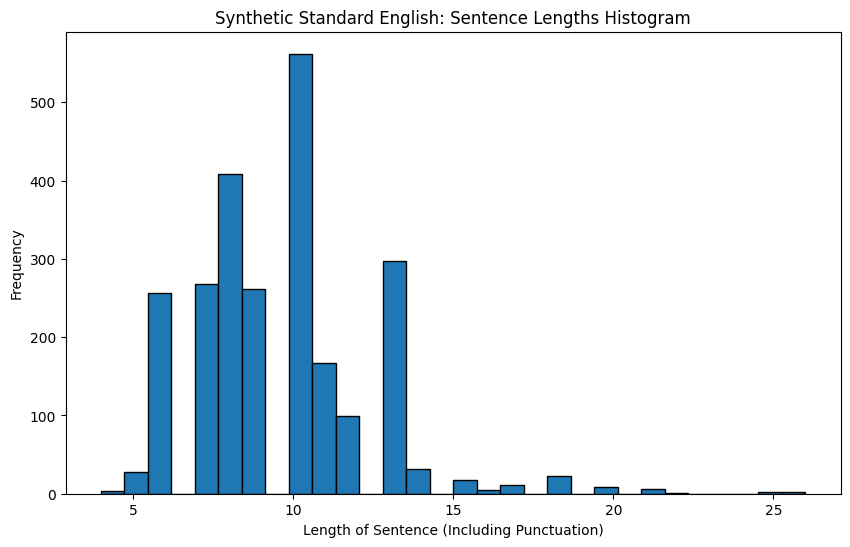

In [ ]:
# Add a column with the word count
sse_df['word_count'] = sse_df['Sentence'].apply(count_words)

# Plot a histogram of sentence length distribution
plt.figure(figsize=(10, 6))
plt.hist(sse_df['word_count'], bins=30, edgecolor='black')
plt.title('Synthetic Standard English: Sentence Lengths Histogram')
plt.xlabel('Length of Sentence (Including Punctuation)')
plt.ylabel('Frequency')
plt.show()

In [10]:
sle_df

,Sentence,word_count
0,I very like to play basketball at weekend.,8
1,I very like play basketball with my friend.,8
2,I go to shopping yesterday.,5
3,I go to the store every day for buy food.,10
4,I go to library every day after school.,8
...,...,...
2495,I go to shop yesterday for buy fruits.,8
2496,I am very interesting in this subject.,7
2497,I go to shop yesterday for buy fruit.,8
2498,She very like play basketball with friends.,7


In [9]:
# Add a column with the word count
sle_df['word_count'] = sle_df['Sentence'].apply(count_words)

KeyError: 'word_count'

<Figure size 1000x600 with 0 Axes>

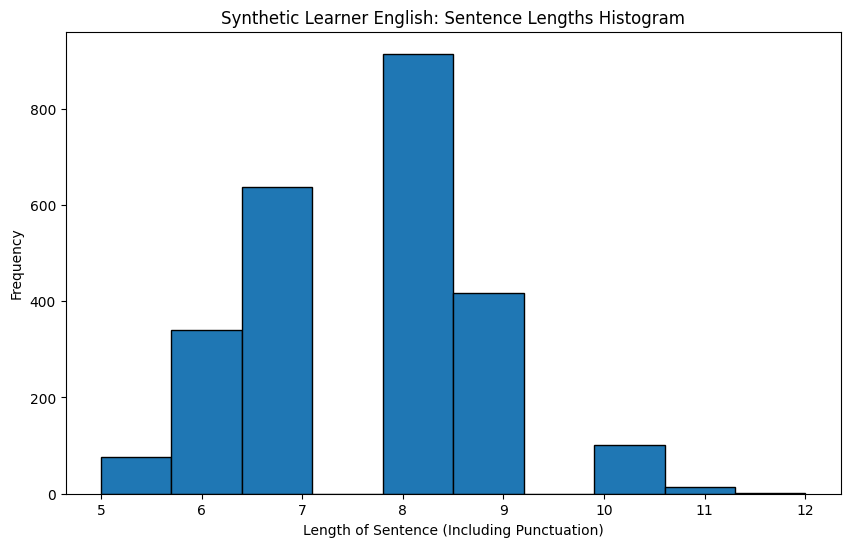

In [13]:
# Plot a histogram of sentence length distribution
plt.figure(figsize=(10, 6))
plt.hist(sle_df['word_count'], bins=10, edgecolor='black')
plt.title('Synthetic Learner English: Sentence Lengths Histogram')
plt.xlabel('Length of Sentence (Including Punctuation)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
mean_word_count = sse_df['word_count'].mean()
median_word_count = sse_df['word_count'].median()
mode_word_count = sse_df['word_count'].mode().iloc[0]  # Mode can have multiple values; take the first
mode_count = (sse_df['word_count'] == mode_word_count).sum()
std_dev_word_count = sse_df['word_count'].std()
total_sentences = len(sse_df)

# Compile the results
stats = {
    "Mean Word Count": mean_word_count,
    "Median Word Count": median_word_count,
    "Mode Word Count": mode_word_count,
    "Mode Count": mode_count,
    "Standard Deviation": std_dev_word_count,
    "Total Sentences": total_sentences,
}

In [ ]:
stats

{'Mean Word Count': 9.561253561253562,
 'Median Word Count': 10.0,
 'Mode Word Count': 10,
 'Mode Count': 562,
 'Standard Deviation': 2.688877390311199,
 'Total Sentences': 2457}

In [14]:
mean_word_count = sle_df['word_count'].mean()
median_word_count = sle_df['word_count'].median()
mode_word_count = sle_df['word_count'].mode().iloc[0]  # Mode can have multiple values; take the first
mode_count = (sle_df['word_count'] == mode_word_count).sum()
std_dev_word_count = sle_df['word_count'].std()
total_sentences = len(sle_df)

# Compile the results
stats_sle = {
    "Mean Word Count": mean_word_count,
    "Median Word Count": median_word_count,
    "Mode Word Count": mode_word_count,
    "Mode Count": mode_count,
    "Standard Deviation": std_dev_word_count,
    "Total Sentences": total_sentences,
}
stats_sle

{'Mean Word Count': 7.6476,
 'Median Word Count': 8.0,
 'Mode Word Count': 8,
 'Mode Count': 914,
 'Standard Deviation': 1.1541000904633343,
 'Total Sentences': 2500}

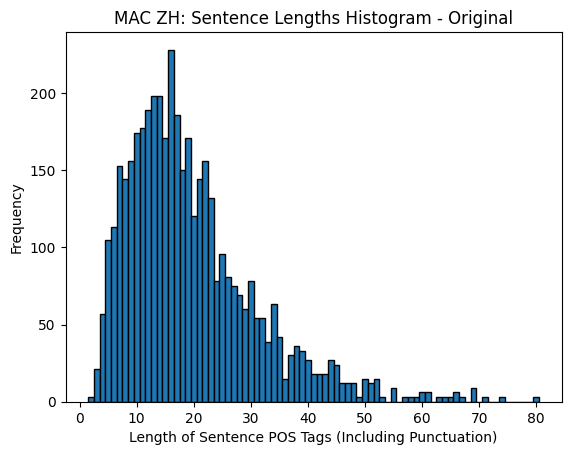

In [ ]:
row_lengths = zh1_df.apply(lambda row: row.count(), axis=1)
plt.hist(row_lengths, bins=range(min(row_lengths), max(row_lengths) + 2), align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("MAC ZH: Sentence Lengths Histogram - Original")
plt.show()

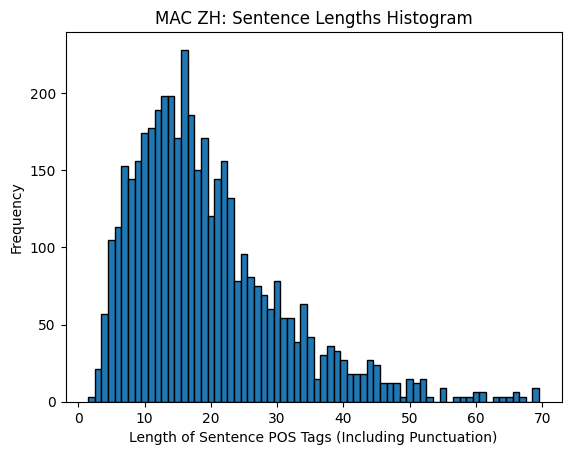

In [ ]:
filtered_mac_zh_tags_df = zh1_df[(row_lengths >= 2) & (row_lengths <= 70)]
filtered_row_lengths = filtered_mac_zh_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(filtered_row_lengths, bins=range(min(filtered_row_lengths), max(filtered_row_lengths) + 2),
         align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("MAC ZH: Sentence Lengths Histogram")
plt.show()

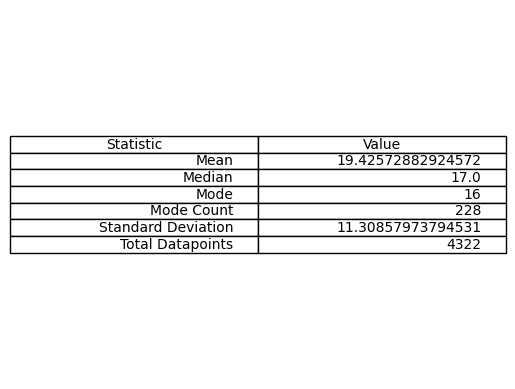

In [ ]:
filtered_row_lengths = filtered_mac_zh_tags_df.apply(lambda row: row.count(), axis=1)
display_stats(filtered_row_lengths)

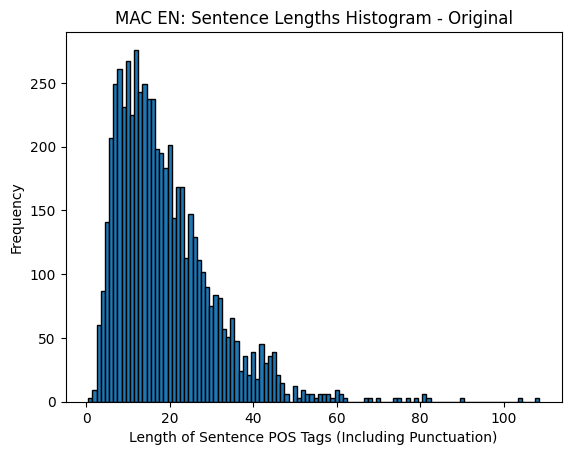

In [ ]:
row_lengths = en1_df.apply(lambda row: row.count(), axis=1)
plt.hist(row_lengths, bins=range(min(row_lengths), max(row_lengths) + 2), align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("MAC EN: Sentence Lengths Histogram - Original")
plt.show()

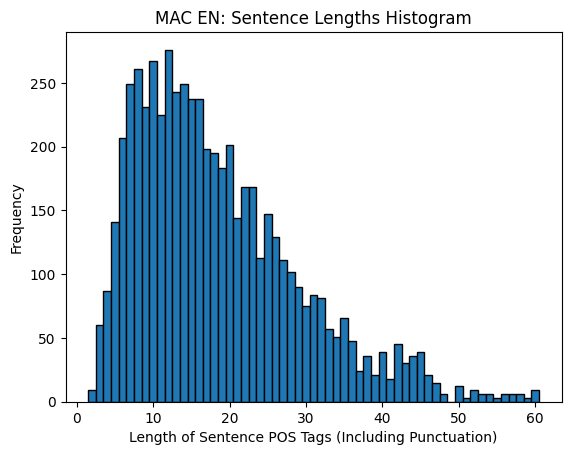

In [ ]:
filtered_mac_en_tags_df = en1_df[(row_lengths >= 2) & (row_lengths <= 60)]
filtered_row_lengths = filtered_mac_en_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(filtered_row_lengths, bins=range(min(filtered_row_lengths), max(filtered_row_lengths) + 2),
         align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("MAC EN: Sentence Lengths Histogram")
plt.show()

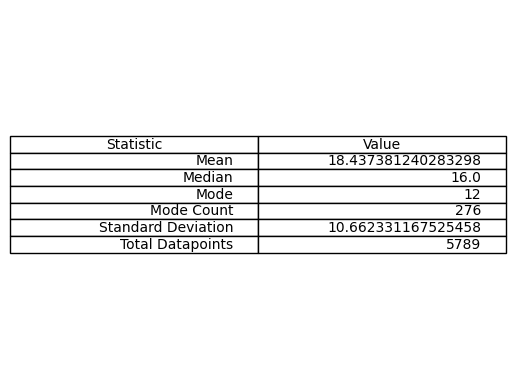

In [ ]:
display_stats(filtered_row_lengths)

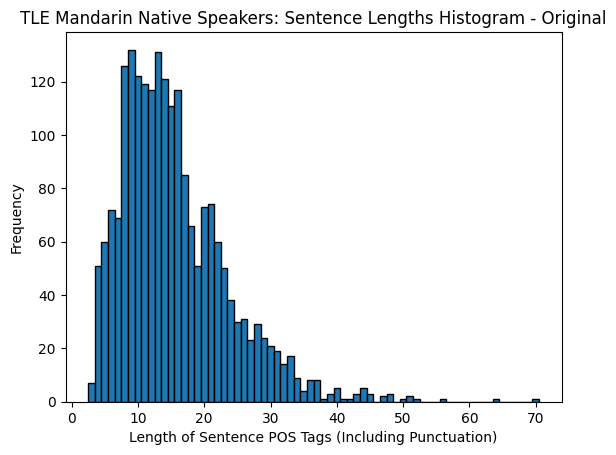

In [ ]:
row_lengths = in_between_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(row_lengths, bins=range(min(row_lengths), max(row_lengths) + 2), align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("TLE Mandarin Native Speakers: Sentence Lengths Histogram - Original")
plt.show()

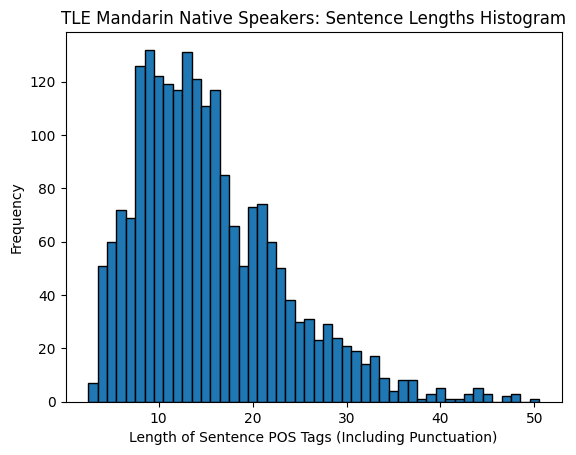

In [ ]:
filtered_inbtwn_tags_df = in_between_tags_df[(row_lengths >= 2) & (row_lengths <= 50)]
filtered_row_lengths = filtered_inbtwn_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(filtered_row_lengths, bins=range(min(filtered_row_lengths), max(filtered_row_lengths) + 2),
         align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("TLE Mandarin Native Speakers: Sentence Lengths Histogram")
plt.show()

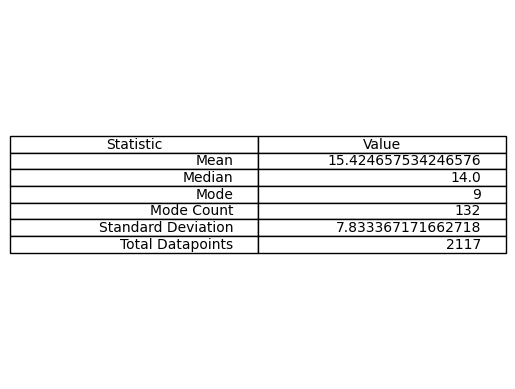

In [ ]:
display_stats(filtered_row_lengths)

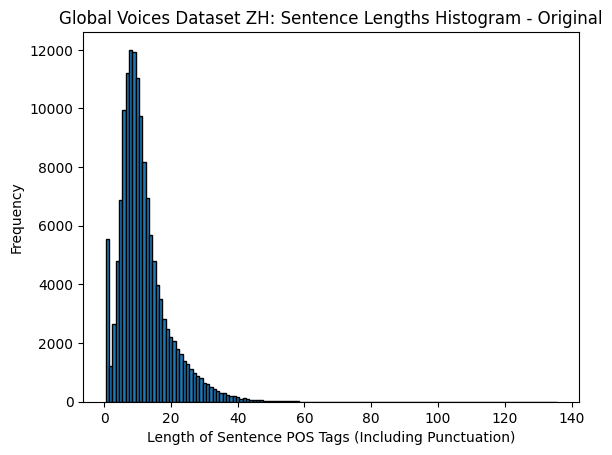

In [ ]:
row_lengths = mandarin_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(row_lengths, bins=range(min(row_lengths), max(row_lengths) + 2), align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("Global Voices Dataset ZH: Sentence Lengths Histogram - Original")
plt.show()

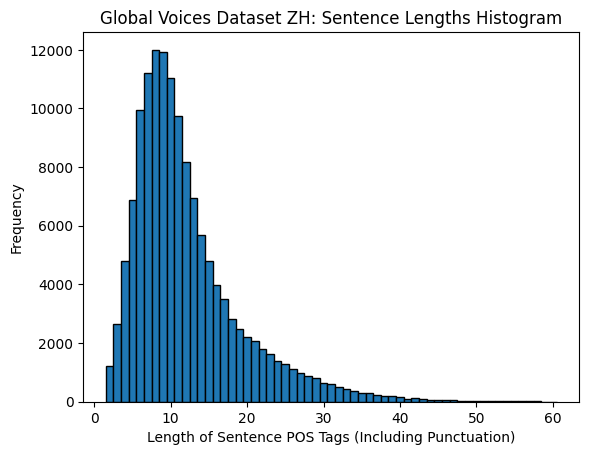

In [ ]:
filtered_mandarin_tags_df = mandarin_tags_df[(row_lengths >= 2) & (row_lengths <= 60)]
filtered_row_lengths = filtered_mandarin_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(filtered_row_lengths, bins=range(min(filtered_row_lengths), max(filtered_row_lengths) + 2),
         align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("Global Voices Dataset ZH: Sentence Lengths Histogram")
plt.show()

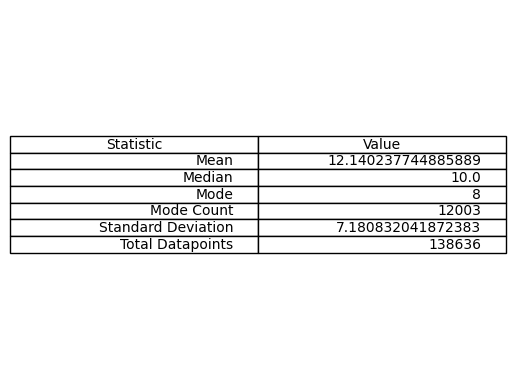

In [ ]:
display_stats(filtered_row_lengths)

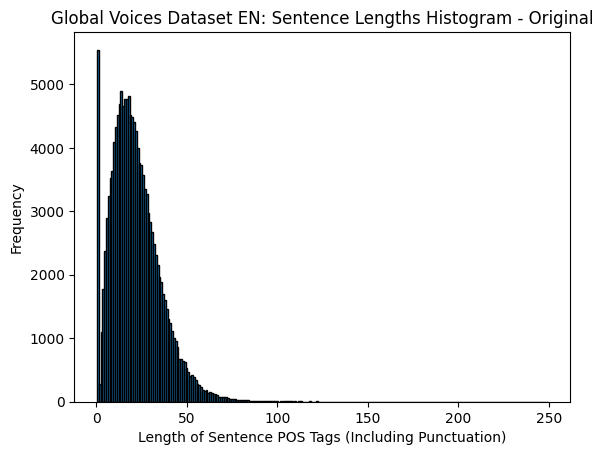

In [ ]:
row_lengths = english_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(row_lengths, bins=range(min(row_lengths), max(row_lengths) + 2), align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("Global Voices Dataset EN: Sentence Lengths Histogram - Original")
plt.show()

In [ ]:
filtered_english_tags_df = english_tags_df[(row_lengths >= 4) & (row_lengths <= 100)]

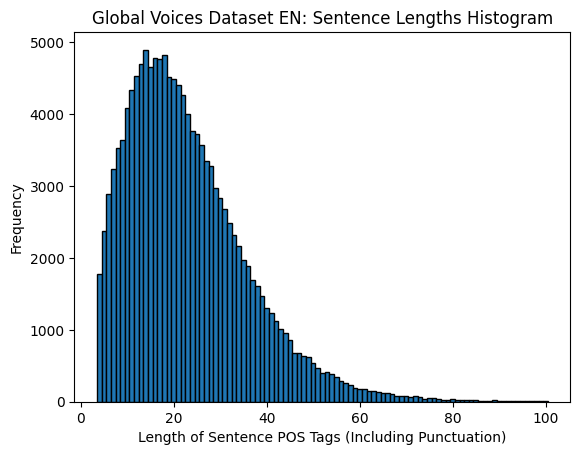

In [ ]:
filtered_row_lengths = filtered_english_tags_df.apply(lambda row: row.count(), axis=1)
plt.hist(filtered_row_lengths, bins=range(min(filtered_row_lengths), max(filtered_row_lengths) + 2),
         align='left', edgecolor='black')
plt.xlabel("Length of Sentence POS Tags (Including Punctuation)")
plt.ylabel("Frequency")
plt.title("Global Voices Dataset EN: Sentence Lengths Histogram")
plt.show()

In [ ]:
max_length = filtered_row_lengths.max()
print(f"The maximum sentence length is: {max_length}")
num_sentences_gt_100 = (filtered_row_lengths > 100).sum()
print(f"Number of sentences greater than 100 characters: {num_sentences_gt_100}")
short_sentences_count = (row_lengths < 3).sum() # 4% have less than 3
print(f"Number of sentences with length less than 3: {short_sentences_count}")
print(f"Total number of sentences: {len(row_lengths)}")

The maximum sentence length is: 249
Number of sentences greater than 100 characters: 128
Number of sentences with length less than 3: 5830
Total number of sentences: 144223


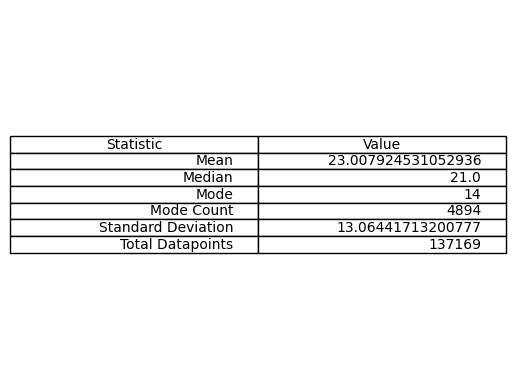

In [ ]:
display_stats(filtered_row_lengths)


In [ ]:
print(f'Length of english tags', len(english_tags_df))
print(f'Length of mandarin tags', len(mandarin_tags_df))
print(f'Length of mandarin tags', len(in_between_tags_df))

Length of english tags 144223
Length of mandarin tags 144223
Length of mandarin tags 2123


##### Identify number of unique POS tags

In [ ]:
all_tags = pd.Series(english_tags_df.values.flatten())
unique_tags = all_tags.unique()
num_tags = len(unique_tags)
print("Number of unique POS tags:", num_tags)
print("Unique POS tags:", unique_tags)

Number of unique POS tags: 19
Unique POS tags: ['DET' 'NOUN' 'ADP' 'VERB' 'ADJ' 'PROPN' 'CCONJ' 'PUNCT' 'SPACE' nan
 'SCONJ' 'AUX' 'NUM' 'ADV' 'PRON' 'PART' 'INTJ' 'X' 'SYM']


In [ ]:
all_tags_zh = pd.Series(mandarin_tags_df.values.flatten())
unique_tags_zh = all_tags_zh.unique()
num_tags_zh = len(unique_tags_zh)
print("Number of unique Mandarin POS tags:", num_tags_zh)
print("Unique POS Mandarin tags:", unique_tags_zh)

Number of unique Mandarin POS tags: 17
Unique POS Mandarin tags: ['PROPN' 'PART' 'VERB' 'PUNCT' 'SPACE' nan 'NOUN' 'PRON' 'ADV' 'NUM' 'ADP'
 'ADJ' 'X' 'DET' 'CCONJ' 'SCONJ' 'INTJ']


In [ ]:
# Find the intersection
intersection = list(set(unique_tags) & set(unique_tags_zh))
print("Intersection:", intersection)
print(len(intersection))

# Find elements in unique_tags but not in the intersection
difference = list(set(unique_tags) - set(intersection))

# Print the result
print("Elements in unique_tags but not in intersection:", difference)

Intersection: ['NOUN', 'CCONJ', 'PROPN', 'DET', 'PRON', 'SCONJ', nan, 'INTJ', 'VERB', 'PUNCT', 'SPACE', 'X', 'ADP', 'PART', 'ADV', 'NUM', 'ADJ']
17
Elements in unique_tags but not in intersection: ['AUX', 'SYM']


##### Create One-Hot Encodings of POS Tags

In [ ]:
# Reference to the one-hot vector positions
tag_order = []
for i, tag in enumerate(intersection):
    tag_order.append(tag)
print(tag_order)

['NOUN', 'CCONJ', 'PROPN', 'DET', 'PRON', 'SCONJ', nan, 'INTJ', 'VERB', 'PUNCT', 'SPACE', 'X', 'ADP', 'PART', 'ADV', 'NUM', 'ADJ']


In [ ]:
pos_to_index = {}
for i, tag in enumerate(unique_tags):
    pos_to_index[tag] = i

def pos_to_one_hot(pos_tag, pos_to_index, num_tags):
    one_hot = np.zeros(num_tags)
    index = pos_to_index[pos_tag]
    one_hot[index] = 1
    return one_hot

In [ ]:
print(f'Length of english tags', len(english_tags_df))
print(f'Length of mandarin tags', len(mandarin_tags_df))

Length of english tags 144223
Length of mandarin tags 144223


In [ ]:
english_tags = english_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
mandarin_tags = mandarin_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
in_between_tags = in_between_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

In [ ]:
new_en1_tags = en1_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
new_zh1_tags = zh1_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

##### Convert Each Sentence's POS Tags to a Matrix

In [ ]:
def matrixify(tags):
  sentence_matrices = []

  for sentence_tags in tags:
      one_hot_vectors = []

      for tag in sentence_tags:
          one_hot_vector = pos_to_one_hot(tag, pos_to_index, num_tags)
          one_hot_vectors.append(one_hot_vector)

      sentence_matrix = np.array(one_hot_vectors)
      sentence_matrices.append(sentence_matrix)

  return sentence_matrices

In [ ]:
sentence_matrices_en = matrixify(english_tags)
sentence_matrices_zh = matrixify(mandarin_tags)

In [ ]:
matrix_en1 = matrixify(new_en1_tags)
matrix_zh1 = matrixify(new_en1_tags)
matrix_inbetween = matrixify(in_between_tags)

##### Create classification label for English/Mandarin

In [ ]:
english_labels = [1] * len(sentence_matrices_en)
mandarin_labels = [0] * len(sentence_matrices_zh)

# combine vectors for rnn
all_sentences_og = sentence_matrices_en + sentence_matrices_zh
all_labels = english_labels + mandarin_labels

In [ ]:
en1_labels = [1] * len(matrix_en1)
zh1_labels = [0] * len(matrix_zh1)

# combine vectors for rnn
all_sentences_new = matrix_en1 + matrix_zh1
all_labels = en1_labels + zh1_labels

In [ ]:
# DEFAULT ALL THE IN BETWEEN SENTENCES TO MANDARIN
in_between_labels = [1] * len(matrix_inbetween)

##### Convert to PyTorch Tensors; Prep to Feed into RNN

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device")

Using 'cuda' device


In [ ]:
# Process Tensors for Input
class POSDataset(Dataset):
    def __init__(self, sentence_matrices, labels):

        # Convert sentence matrices to PyTorch tensors
        sentence_tensors = []
        for matrix in sentence_matrices:
            sentence_tensor = torch.tensor(matrix, dtype=torch.float32)
            sentence_tensors.append(sentence_tensor)
        self.sentence_matrices = sentence_tensors

        # Convert labels to a 1D PyTorch tensor (flatten)
        label_list = []
        for label in labels:
            label_list.append(label)
        self.labels = torch.tensor(label_list, dtype=torch.long)

    # getter fct for length of sentence
    def __len__(self):
        return len(self.sentence_matrices)

    def __getitem__(self, index):
        return self.sentence_matrices[index], self.labels[index]

##### Apply the preparation function

In [ ]:
dataset = POSDataset(all_sentences, all_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Dataloader wraps an iterable around the dataset for improved access
# Create dataloaders from dataset
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [ ]:
def collate_fn(batch):
    # Extract sentences and labels from the batch
    sentences, labels = zip(*batch)

    # Pad sentences to the same length along the first dimension (number of words)
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=0)

    # Stack the labels into a tensor
    labels = torch.stack(labels)

    return padded_sentences, labels

In [ ]:
eval_dataset = POSDataset(all_sentences, all_labels)
eval_loader = DataLoader(eval_dataset, batch_size=len(all_sentences), shuffle=True) # pad sentences to the same length

In [ ]:
eval_loader = DataLoader(eval_dataset, batch_size=len(all_sentences), shuffle=True, collate_fn=collate_fn)

# Iterate through the eval_loader
for batch in eval_loader:
    sentences, labels = batch
    print("Sentences:", sentences)
    print("Labels:", labels)

Sentences: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0

In [ ]:
dataset_inbtwn = POSDataset(sentence_matrices_inbtwn, in_between_labels)

##### RNN Model

In [ ]:
# RNN Model Creation
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size, bias=False) # input to hidden
        self.h2h = nn.Linear(hidden_size, hidden_size) # hidden to hidden
        self.h2o = nn.Linear(hidden_size, output_size) # hidden to output
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        output = self.h2o(hidden_state)
        return self.softmax(output), hidden_state

    def init_hidden(self, batch_size=1):
        return torch.zeros(1, self.hidden_size)

##### Implement RNN Training

In [ ]:
# initialize
input_size = all_sentences[0].shape[1] # num features per POS tag; length of one-hot vector, 17
hidden_size = 16 # num of hidden units
output_size = 2 # binary classification (1 for eng, 0 zh)

# create model, optimizer, and loss
model = RNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fct = nn.NLLLoss() # neg log likelihood loss fct

In [ ]:
# train the function
def train_model(model, train_loader, epochs, optimizer, loss_fct, checkpoint_path='/content/drive/My Drive/IW_Codebase/checkpoints/model_checkpoint.pth'):
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        # initialize tqdm progress bar for training loop
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=True)

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            hidden = model.init_hidden().to(device)

            # zero gradients
            optimizer.zero_grad()

            # process each step in the seq
            loss = 0
            for i in range(X.size(1)):
                output, hidden = model(X[:, i, :], hidden)
                loss += loss_fct(output, y)

            # backprop + update weights
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 3) # gradient clipping for performance
            optimizer.step()

            total_loss += loss.item() / X.size(1)

            progress_bar.set_postfix(loss=loss.item() / X.size(1))

        # save model checkpoint at the end of each epoch
        torch.save(model.state_dict(), checkpoint_path)

        # Print epoch loss
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

    final_checkpoint_path = 'final_model_weights.pth'
    torch.save(model.state_dict(), final_checkpoint_path)
    print(f'Final model weights saved to {final_checkpoint_path}')

##### Train model

In [ ]:
train_model(model, train_loader, epochs=10, optimizer=optimizer, loss_fct=loss_fct)

Epoch 1/10: 100%|██████████| 230756/230756 [48:49<00:00, 78.77it/s, loss=0.0218]


Epoch 1/10, Loss: 0.4616


Epoch 2/10: 100%|██████████| 230756/230756 [50:01<00:00, 76.87it/s, loss=0.13]


Epoch 2/10, Loss: 0.4314


Epoch 3/10: 100%|██████████| 230756/230756 [48:22<00:00, 79.50it/s, loss=3.56]


Epoch 3/10, Loss: 0.4244


Epoch 4/10: 100%|██████████| 230756/230756 [47:28<00:00, 81.02it/s, loss=0.00266]


Epoch 4/10, Loss: 0.4214


Epoch 5/10: 100%|██████████| 230756/230756 [48:00<00:00, 80.12it/s, loss=0.00656]


Epoch 5/10, Loss: 0.4147


Epoch 6/10: 100%|██████████| 230756/230756 [47:22<00:00, 81.18it/s, loss=0.297]


Epoch 6/10, Loss: 0.4121


Epoch 7/10: 100%|██████████| 230756/230756 [47:34<00:00, 80.83it/s, loss=0.175]


Epoch 7/10, Loss: 0.4118


Epoch 8/10: 100%|██████████| 230756/230756 [47:35<00:00, 80.81it/s, loss=0.000507]


Epoch 8/10, Loss: 0.4086


Epoch 9/10:  10%|█         | 23968/230756 [04:57<49:14, 69.99it/s, loss=0.819]  

##### Evaluate the saved final model weights

In [ ]:
model = RNN(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_1.pth'))
model.eval()

<ipython-input-32-00648f2b279c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/IW_Codebase/checkpoints/model_chec

RNN(
  (i2h): Linear(in_features=19, out_features=16, bias=False)
  (h2h): Linear(in_features=16, out_features=16, bias=True)
  (h2o): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# for param_tensor in model.state_dict():
#     print(f"{param_tensor}: {model.state_dict()[param_tensor].size()}")
#     print(model.state_dict()[param_tensor])  # Display the actual weights

In [ ]:
def predict(model, sentence_tensor):
    model.eval()
    with torch.no_grad():
        sentence_tensor = sentence_tensor.to(device)  # Move data to the correct device
        batch_size = sentence_tensor.size(0)
        hidden = model.init_hidden(batch_size).to(device)  # Initialize hidden state for the batch

        for i in range(sentence_tensor.size(1)):  # Iterate through the sequence length
            output, hidden = model(sentence_tensor[:, i, :], hidden)

        # Take the last output as the prediction for each sample in the batch
        _, predicted_labels = torch.max(output, 1)  # Get predicted class indices
        return predicted_labels

In [ ]:
# Evaluate model accuracy using eval_loader
correct_predictions = 0
total_samples = 0

for batch in eval_loader:
    # Unpack the batch
    sentence_tensors, actual_labels = batch
    sentence_tensors, actual_labels = sentence_tensors.to(device), actual_labels.to(device)

    # Predict labels for the entire batch
    predicted_labels = predict(model, sentence_tensors)

    # Compare predictions with actual labels
    correct_predictions += (predicted_labels == actual_labels).sum().item()
    total_samples += actual_labels.size(0)

    # Optionally print each comparison for debugging
    for actual, predicted in zip(actual_labels, predicted_labels):
        print(f'Actual: {actual.item()}, Predicted: {predicted.item()}', end=' | ')

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f'\nAccuracy: {accuracy:.4%}')

Actual: 1, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 1, Predicted: 0 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 1, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, Predicted: 1 | Actual: 0, P

In [ ]:
print(len(eval_dataset))

11680
